# pyspark ml

###  Initialization and Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("pyspark ml").getOrCreate()

24/06/17 16:32:29 WARN Utils: Your hostname, MACHINE resolves to a loopback address: 127.0.1.1; using 10.10.205.14 instead (on interface wlp2s0)
24/06/17 16:32:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/17 16:32:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/17 16:32:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/06/17 16:32:41 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### 1. pyspark.ml.regression - LinearRegression

In [2]:
# Load data
auto_mpg = spark.read.csv('Datasets/car.csv', header=True, inferSchema=True)

In [3]:
# Select relevant columns and handle missing values
auto_mpg = auto_mpg.select(['mpg', 'cylinders', 'displacement', 'weight', 'acceleration', 'horsepower'])

In [4]:
# Convert '?' in 'horsepower' to NULL and cast to float
auto_mpg = auto_mpg.withColumn('horsepower', auto_mpg['horsepower'].cast('float'))

In [5]:
# Drop rows with NULL values after conversion
auto_mpg = auto_mpg.dropna()

In [6]:
# Assemble features
assembler = VectorAssembler(inputCols=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'], outputCol='features')
data = assembler.transform(auto_mpg).select('mpg', 'features')

In [7]:
# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [8]:
# Initialize linear regression model
lr = LinearRegression(labelCol='mpg', featuresCol='features')

In [9]:
# Fit the model
lr_model = lr.fit(train_data)

24/06/17 16:32:47 WARN Instrumentation: [e209c29e] regParam is zero, which might cause numerical instability and overfitting.
24/06/17 16:32:48 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


In [10]:
# Print coefficients and intercept
print(f"Coefficients: {lr_model.coefficients}")
print(f"Intercept: {lr_model.intercept}")

Coefficients: [-0.33968738424777434,-0.006650480552148412,-0.03777952819502111,-0.004784693755319047,-0.0013351149647201385]
Intercept: 44.75766283135702


In [11]:
# Predict on test data
predictions = lr_model.transform(test_data)

In [12]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='mpg', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 4.510353454105783


In [13]:
# Calculate accuracy and confusion matrix
predictions_and_labels = predictions.select("prediction", "mpg")
predictions_and_labels = predictions_and_labels.withColumn('prediction', F.round(F.col('prediction'), 0))
predictions_and_labels = predictions_and_labels.withColumn('mpg', F.round(F.col('mpg'), 0))
predictions_and_labels = predictions_and_labels.withColumnRenamed('prediction', 'predicted_mpg')

In [14]:
# Convert to Pandas DataFrame for calculating confusion matrix
predictions_pandas = predictions_and_labels.toPandas()

In [15]:
# Calculate confusion matrix
confusion_matrix = predictions_pandas.groupby(['mpg', 'predicted_mpg']).size().unstack(fill_value=0)

In [16]:
# Calculate accuracy
accuracy = predictions_pandas[predictions_pandas['mpg'] == predictions_pandas['predicted_mpg']].shape[0] / predictions_pandas.shape[0]
print(f"Accuracy: {accuracy}")

Accuracy: 0.16666666666666666


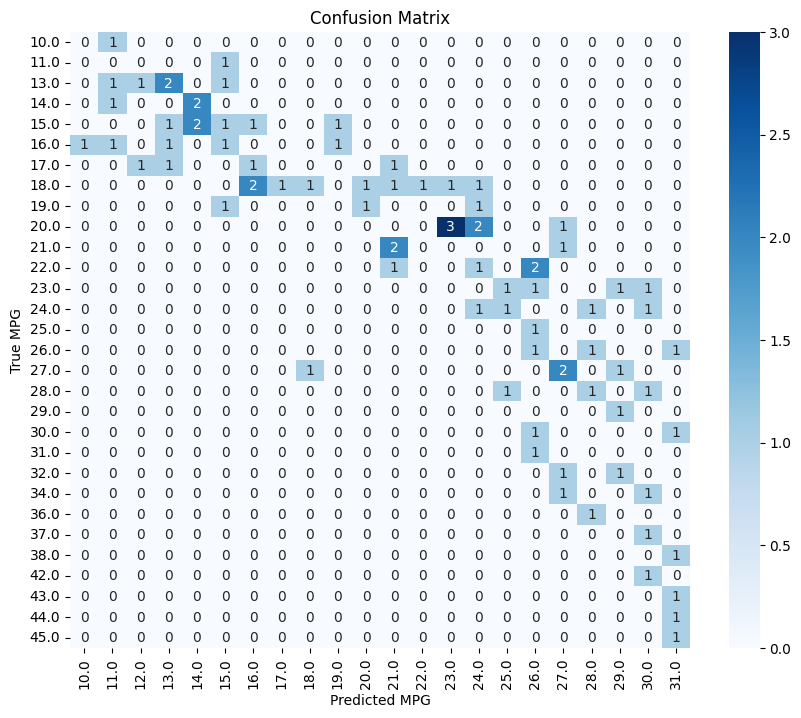

In [17]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted MPG')
plt.ylabel('True MPG')
plt.show()

### 2. pyspark.ml.regression - DecisionTreeRegressor

In [18]:
from pyspark.ml.regression import DecisionTreeRegressor

In [19]:
# Load data
auto_mpg = spark.read.csv('Datasets/car.csv', header=True, inferSchema=True)

In [20]:
# Select relevant columns and handle missing values
auto_mpg = auto_mpg.select(['mpg', 'cylinders', 'displacement', 'weight', 'acceleration', 'horsepower'])

In [21]:
# Convert '?' in 'horsepower' to NULL and cast to float
auto_mpg = auto_mpg.withColumn('horsepower', auto_mpg['horsepower'].cast('float'))

In [22]:
# Drop rows with NULL values after conversion
auto_mpg = auto_mpg.dropna()

In [23]:
# Assemble features
assembler = VectorAssembler(inputCols=['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration'], outputCol='features')
data = assembler.transform(auto_mpg).select('mpg', 'features')

In [24]:
# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

In [25]:
# Initialize decision tree regression model
dt = DecisionTreeRegressor(labelCol='mpg', featuresCol='features')

In [26]:
# Fit the model
dt_model = dt.fit(train_data)

In [27]:
# Print feature importances (optional for decision tree)
print(f"Feature Importances: {dt_model.featureImportances}")

Feature Importances: (5,[0,1,2,3,4],[0.01738601591718769,0.7541323579397138,0.16136933672175668,0.024802987860371644,0.04230930156097027])


In [28]:
# Predict on test data
predictions = dt_model.transform(test_data)

In [29]:
# Evaluate the model
evaluator = RegressionEvaluator(labelCol='mpg', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 4.427832292006243


In [30]:
# Calculate accuracy and confusion matrix
predictions_and_labels = predictions.select("prediction", "mpg")
predictions_and_labels = predictions_and_labels.withColumn('prediction', F.round(F.col('prediction'), 0))
predictions_and_labels = predictions_and_labels.withColumn('mpg', F.round(F.col('mpg'), 0))
predictions_and_labels = predictions_and_labels.withColumnRenamed('prediction', 'predicted_mpg')

In [31]:
# Convert to Pandas DataFrame for calculating confusion matrix
predictions_pandas = predictions_and_labels.toPandas()

In [32]:
# Calculate confusion matrix
confusion_matrix = predictions_pandas.groupby(['mpg', 'predicted_mpg']).size().unstack(fill_value=0)

In [33]:
# Calculate accuracy
accuracy = predictions_pandas[predictions_pandas['mpg'] == predictions_pandas['predicted_mpg']].shape[0] / predictions_pandas.shape[0]
print(f"Accuracy: {accuracy}")

Accuracy: 0.14285714285714285


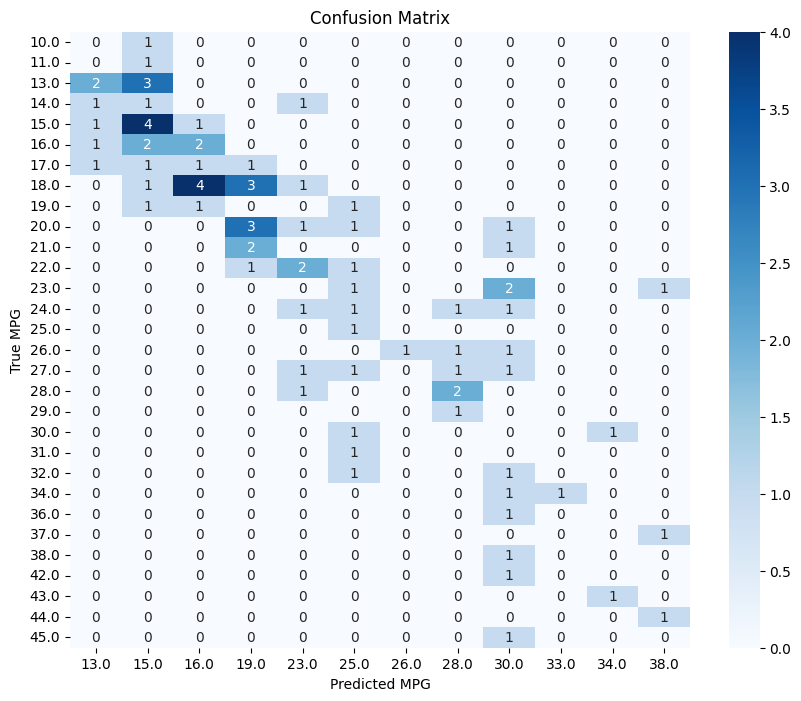

In [34]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted MPG')
plt.ylabel('True MPG')
plt.show()

### 3. pyspark.ml.clustering - KMeans

In [35]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [36]:
#  Load the dataset
dataset = spark.read.csv("Datasets/seeds_dataset.csv", header=True, inferSchema=True)

In [37]:
#  Format the data using Vector Assembler into vectors which will be used as “features”
vec_assembler = VectorAssembler(inputCols=dataset.columns, outputCol='features')
final_data = vec_assembler.transform(dataset)

In [38]:
#  Scaling the data
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(final_data)
final_data = scalerModel.transform(final_data)

Silhouette Score for k = 2 is 0.5926693325178973
Silhouette Score for k = 3 is 0.6915197728249729
Silhouette Score for k = 4 is 0.5731442637928086
Silhouette Score for k = 5 is 0.4582423961436169
Silhouette Score for k = 6 is 0.3865090999629287
Silhouette Score for k = 7 is 0.43648887842152545
Silhouette Score for k = 8 is 0.4141845237442903
Silhouette Score for k = 9 is 0.3781675566105115


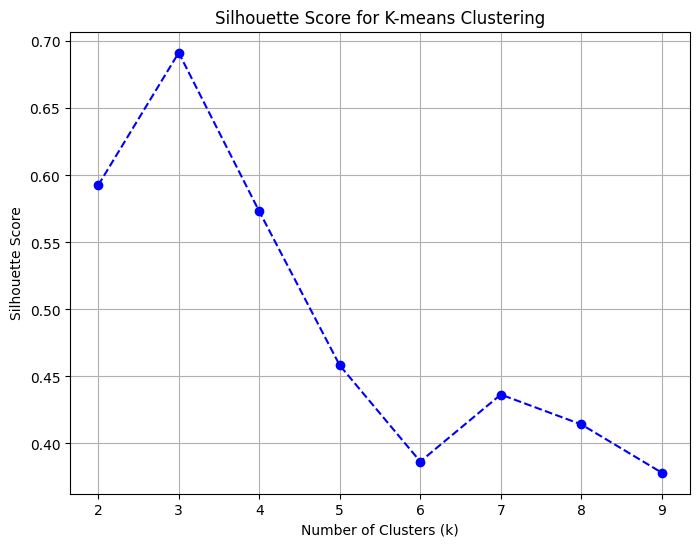

In [39]:
#  Find the number of clusters using Silhouette Score
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaledFeatures', metricName='silhouette')

for k in range(2, 10):
    kmeans = KMeans(featuresCol='scaledFeatures', k=k)
    model = kmeans.fit(final_data)
    predictions = model.transform(final_data)
    score = evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print(f'Silhouette Score for k = {k} is {score}')

# Plot the Silhouette Score graph
plt.figure(figsize=(8, 6))
plt.plot(range(2, 10), silhouette_score, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-means Clustering')
plt.grid(True)
plt.show()

In [40]:
# Based on the Silhouette Score graph, select the optimal k (let's assume k=3)
optimal_k = 3

In [41]:
# Train the Model
kmeans = KMeans(featuresCol='scaledFeatures', k=optimal_k)
model = kmeans.fit(final_data)
predictions = model.transform(final_data)

In [42]:
# Print cluster centers
print("Cluster Centers: ")
centers = model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

Cluster Centers: 
Cluster 0: [ 6.31258132 12.36956615 37.37677676 13.90987399  9.73978409  2.40568558
 12.27254041  2.40874137]
Cluster 1: [ 4.91494065 10.93132337 37.25846176 12.39806224  8.58634283  1.792494
 10.32818191  1.25673463]
Cluster 2: [ 4.08078478 10.1441622  35.94708183 11.80308138  7.55536747  3.18471437
 10.41017906  3.665476  ]


In [43]:
# Showing the result of groupings
predictions.select('prediction').show(15)

+----------+
|prediction|
+----------+
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
|         0|
|         1|
|         1|
|         1|
|         1|
|         1|
|         1|
+----------+
only showing top 15 rows

